# **RNN Introduction**


## Importing required libraries


In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose


## Loading and preprocessing the data
### Dataset 4-Deep learning/5-Time Series Forecasting (RNN)/LAB/ٌDatasets/traffic.csv

In [2]:
df= pd.read_csv('traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [4]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [5]:
df.isna().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

## Visualization

In [6]:
result = seasonal_decompose(df['Vehicles'], model='multiplicative', period=12)


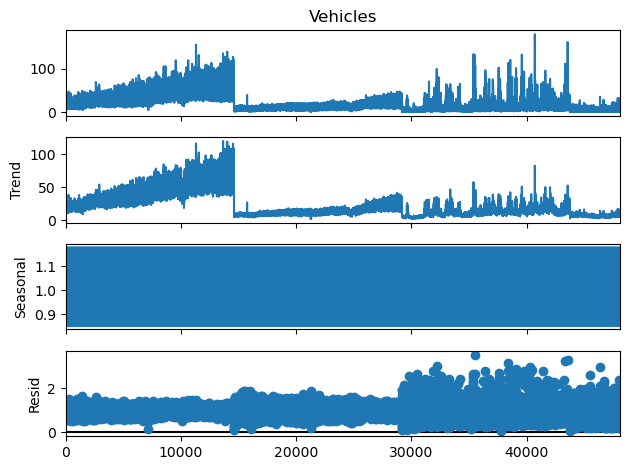

In [7]:
result.plot()
plt.show()

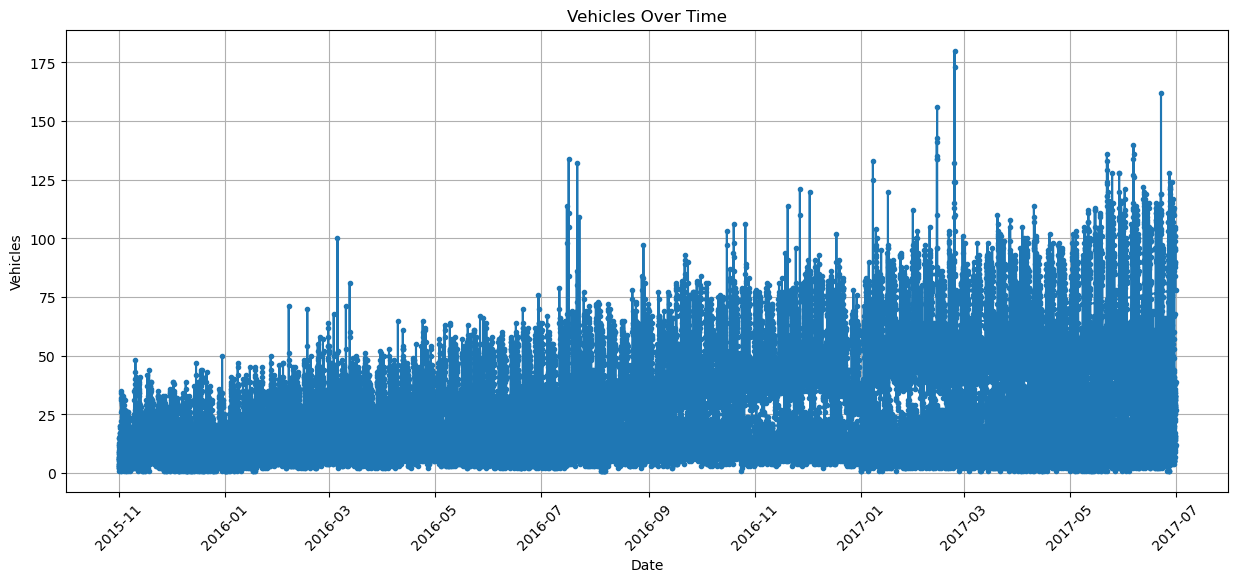

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(df['DateTime'], df['Vehicles'], marker='.')
plt.title('Vehicles Over Time')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Split the data into train and test

In [17]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
num_col = df.select_dtypes(include=['int64']).columns

scaled_data=scaler.fit_transform(df[num_col])
scaled_df = pd.DataFrame(scaled_data, columns=num_col)

scaled_df.head()

,Junction,Vehicles,ID
0,0.0,0.078212,0.000000e+00
1,0.0,0.067039,5.120530e-07
2,0.0,0.050279,1.024106e-06
3,0.0,0.033520,1.536159e-06
4,0.0,0.044693,2.048212e-06


In [22]:
df.head()
df['DateTime']

0       2015-11-01 00:00:00
1       2015-11-01 01:00:00
2       2015-11-01 02:00:00
3       2015-11-01 03:00:00
4       2015-11-01 04:00:00
                ...        
48115   2017-06-30 19:00:00
48116   2017-06-30 20:00:00
48117   2017-06-30 21:00:00
48118   2017-06-30 22:00:00
48119   2017-06-30 23:00:00
Name: DateTime, Length: 48120, dtype: datetime64[ns]

In [26]:
df = pd.concat([scaled_df, df['DateTime']], axis=1)

df.head()

,Junction,Vehicles,ID,DateTime
0,0.0,0.078212,0.000000e+00,2015-11-01 00:00:00
1,0.0,0.067039,5.120530e-07,2015-11-01 01:00:00
2,0.0,0.050279,1.024106e-06,2015-11-01 02:00:00
3,0.0,0.033520,1.536159e-06,2015-11-01 03:00:00
4,0.0,0.044693,2.048212e-06,2015-11-01 04:00:00


In [27]:
# Split into training and testing sets
train_size = int(len(df) * 0.8)  # 80% for training
train_data, test_data = df[:train_size], df[train_size:]

In [29]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for RNN
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data.iloc[i - n_past:i, 0].values)  #using .iloc for positional indexing
    y_train.append(train_data.iloc[i, 0])  #use .iloc for positional indexing
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data.iloc[i - n_past:i, 0].values)  #using .iloc for positional indexing
    y_test.append(test_data.iloc[i, 0])  # using .iloc for positional indexing
X_test, y_test = np.array(X_test), np.array(y_test)


In [30]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(38436, 60)
(38436,)


Testing set size:-
(9564, 60)
(9564,)


(None, None)

In [31]:
# Reshape input data for RNN([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Modeling


In [32]:
# Initialize a sequential model
model = Sequential()

# First RNN layer with 50 units, input shape, and return sequences
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second RNN layer with 50 units and return sequences
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third RNN layer with 50 units
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [33]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [37]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our RNN model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=10,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/10
1202/1202 [==============================] - 62s 52ms/step - loss: 4.4451e-04 - val_loss: 0.0474
Epoch 2/10
1202/1202 [==============================] - 69s 57ms/step - loss: 4.3505e-04 - val_loss: 0.0513
Epoch 3/10
1202/1202 [==============================] - 68s 57ms/step - loss: 4.2238e-04 - val_loss: 0.0583
Epoch 4/10
1202/1202 [==============================] - 53s 44ms/step - loss: 4.2351e-04 - val_loss: 0.0527
Epoch 5/10
1202/1202 [==============================] - 57s 47ms/step - loss: 4.2014e-04 - val_loss: 0.0559
Epoch 6/10
1202/1202 [==============================] - 56s 46ms/step - loss: 4.2125e-04 - val_loss: 0.0504
Epoch 7/10
1202/1202 [==============================] - 54s 45ms/step - loss: 4.2022e-04 - val_loss: 0.0484
Epoch 8/10
1202/1202 [==============================] - 61s 51ms/step - loss: 4.1934e-04 - val_loss: 0.0574
Epoch 9/10
1202/1202 [==============================] - 68s 56ms/step - loss: 4.0729e-04 - val_loss: 0.0550
Epoch 10/10
1202/1202 [=====

In [38]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

299/299 [==============================] - 7s 22ms/step


In [39]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.004133511455662713
0.2274696259929651


## Visualization of results


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

look_back = 60


trainPredictPlot = np.empty_like(df['Vehicles'])
trainPredictPlot[:] = np.nan

trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

testPredictPlot = np.empty_like(df['Vehicles'])
testPredictPlot[:] = np.nan

test_start = len(df) - len(test_predict)

testPredictPlot[test_start:] = test_predict.flatten()


original_scaled_data = scaler.inverse_transform(scaled_data)

plt.figure(figsize=(15, 6))
plt.plot(df.index, original_scaled_data, color='black', label="Actual Traffic Volume")
plt.plot(df.index, trainPredictPlot, color='red', label="Predicted Traffic Volume (Train Set)")
plt.plot(df.index, testPredictPlot, color='blue', label="Predicted Traffic Volume (Test Set)")

plt.title("Traffic Volume Predictions")
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()
